Import and read data and fill data features

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import itertools

from scipy.spatial.distance import cdist
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('iris.data', header=None)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

data_features = data.drop('class', axis=1)
data_list = data_features.values.tolist()
number_of_cluster = 3

data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


euc;idean metric distance for every two point - fitness function

In [9]:
def euclidean_distance(vectors):
    vectors_array = np.array(vectors)

    distances = cdist(vectors_array, vectors_array, metric='euclidean')

    return distances


def fitness(genotype, num_clusters=3):
    cluster_distances = []
    global data_features
    cluster_points = [[], [], []]
    for i in range(150):
        cluster_points[genotype[i]].append(data_list[i])

    for cluster in cluster_points:
        if len(cluster) > 1:
            pairwise_distances = euclidean_distance(cluster)
            cluster_distances.append(np.sum(pairwise_distances))

    total_fitness = np.sum(cluster_distances) if len(cluster_distances) > 0 else np.inf
    return total_fitness

set hyper parameters

In [10]:
population_size = 1000
num_generations = 600
mutation_rate = 0.25
crossover_rate = 0.35

population = []

cross over function and mutation function

In [11]:
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 2)

    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    for i in range(len(offspring1)):
        if random.random() < crossover_rate:
            offspring1[i] = parent1[i]
        if random.random() > 1 - crossover_rate:
            offspring2[i] = parent2[i]

    return offspring1, offspring2


def mutation(genotype):
    mutated_genotype = genotype.copy()
    for i in range(len(mutated_genotype) - 1):
        if random.random() < mutation_rate:
            mutated_genotype[i] = random.randint(0, 2)
    return mutated_genotype

generate first population randomly function

In [12]:
def create_initial_population(initial_population_size, num_clusters=number_of_cluster, dataset_size=150):
    global population

    for _ in range(initial_population_size):
        cluster_assignments = [random.randint(0, num_clusters - 1) for _ in range(dataset_size)]
        individual = cluster_assignments + [0]
        fitness_value = fitness(cluster_assignments)
        individual[-1] = fitness_value
        population.append(individual)

generate next generation

In [13]:
def generate_next_generation(current_population, selection_factor=0.25):
    current_population.sort(key=lambda x: x[-1])

    num_best_individuals = int(len(current_population) * selection_factor)
    best_individuals = current_population[:num_best_individuals]

    num_new_individuals = len(current_population) - num_best_individuals
    new_individuals = []

    while len(new_individuals) < num_new_individuals:
        parent1, parent2 = random.sample(best_individuals, 2)

        offspring1, offspring2 = crossover(parent1[:-1], parent2[:-1])

        mutated_offspring1 = mutation(offspring1)
        mutated_offspring1.append(fitness(offspring1))
        new_individuals.append(mutated_offspring1)

        mutated_offspring2 = mutation(offspring2)
        mutated_offspring2.append(fitness(offspring2))
        new_individuals.append(mutated_offspring2)

    next_generation = best_individuals + new_individuals
    next_generation.sort(key=lambda x: x[-1])
    return next_generation[:len(current_population)]


iterate on generation function

In [14]:
def run_genetic_algorithm(max_iterations = num_generations):
    global population
    create_initial_population(population_size)

    best_fitness = float('inf')
    best_genotype = None
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        population = generate_next_generation(population)
        best_individual = min(population, key=lambda x: x[-1])
        if best_individual[-1] < best_fitness:
            best_fitness = best_individual[-1]
            best_genotype = best_individual[:-1]

    return best_genotype, best_fitness, iteration

result

In [15]:
best_genotype, best_fitness, iteration = run_genetic_algorithm()
print("iteration number : ", iteration , "fitness : ", best_fitness)

iteration number :  600 fitness :  12788.9065019616


insert labels

In [16]:
def try_all_label_assignments(cluster_assignments, data):
    best_accuracy = 0
    best_labels = None

    # Generate all possible label assignments
    labels_permutations = list(itertools.permutations(np.unique(data['class']), len(np.unique(data['class']))))

    for labels in labels_permutations:
        assigned_labels = [labels[cluster] for cluster in cluster_assignments]
        accuracy = accuracy_score(data['class'], assigned_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_labels = assigned_labels

    return best_labels, best_accuracy

new result

In [17]:
best_labels, best_accuracy = try_all_label_assignments(best_genotype, data)
print(best_accuracy)

0.62


plot results

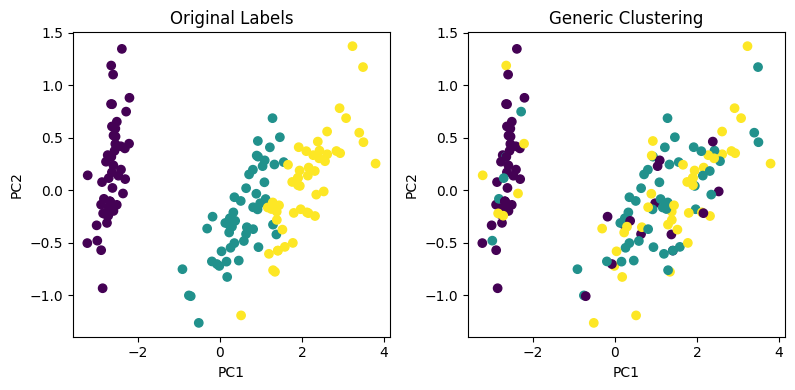

Generic Clustering Accuracy: 0.62


In [18]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.iloc[:, :-1])

data_wih_numeric_label = data.copy()
mapping = {'Iris-setosa': 0,  'Iris-versicolor': 1, 'Iris-virginica' : 2}
data_wih_numeric_label['class'] = data_wih_numeric_label['class'].replace(mapping)
original_labels = data_wih_numeric_label['class']

generic_labels = best_genotype

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=original_labels, cmap='viridis')
plt.title('Original Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=generic_labels, cmap='viridis')
plt.title('Generic Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

_, generic_accuracy = try_all_label_assignments(generic_labels, data)

print("Generic Clustering Accuracy:", generic_accuracy)